<a href="https://colab.research.google.com/github/CD-GRUPO3/TA047R-1C2025-GRUPO03/blob/main/TA047R_TP1_GRUPO03_ENTREGA_EJ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Grupo 3 - Ejercicio 1: *Análisis exploratorio de datos*
**Objetivo:** realizar un análisis completo del conjunto de datos, aplicar técnicas de exploración y de preprocesamiento para poder responder algunas preguntas que se planteen sobre los datos.

**Conjunto de datos:** [uso de Taxis Yellow Cab en USA](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page), particularmente los meses **Julio**, **Agosto** y **Septiembre**.

**Integrantes:**
- ARIAS, Rafaela Pilar. 112272. rparias@fi.uba.ar.
- BARCALA ROCA, Ramiro. 112478. rbarcala@fi.uba.ar.
- LEMA, Mora. 111831. molema@fi.uba.ar.
- IENCO, Lara Eliana. 111921. lienco@fi.uba.ar.

___

####Bibliografía:
Julca, J. E. (2025, febrero 22). Tipos de variables estadísticas: Cuantitativas y Cualitativas. Escuela de Investigación. Recuperado de: [Link](https://escueladeinvestigacion.com/2025/02/22/tipos-de-variables-estadisticas-cuantitativas-y-cualitativas/).

Sin Autor, (2022, junio 7). ¿Qué es una variable discreta? (ejemplos). Probabilidad y Estadística. [Link](https://www.probabilidadyestadistica.net/variable-discreta/).


#####Inicialiación del entorno

In [ ]:
#Importar las bibliotecas
import matplotlib.pyplot as plt   #Generación de gráficos
import matplotlib.ticker as ticker

import numpy as np                #Operaciones matemáticas y estadísticas
import seaborn as sns             #Generación de gráficos
import pandas as pd               #Manipulación y análisis de datos
import pyarrow.parquet as pq      #Trabajar con archivos .parquet
import plotly.express as px

#Configurar Pandas para que no use notación científica (CUALQUIER COSA ELIMINAR!!)
pd.set_option('display.float_format', '{:.6f}'.format)


In [ ]:
#Cargar los datos al Notebook

#Datasets
!gdown 1iju9XQghLYI4-XcDt1TVDE1O9ZwRyFVg
!gdown 1MukhnrymZ35FVsahXUs5I0cAeGJMoXgG
!gdown 1hEhbxXEC7Dc4iG0fKk2k1n8KM6emWxSg

#CSV de estaciones
!gdown 121-MQOXDQI1uTDXgiDETE4VSId1qnYSB

Downloading...
From: https://drive.google.com/uc?id=1iju9XQghLYI4-XcDt1TVDE1O9ZwRyFVg
To: /content/yellow_tripdata_2024-07.parquet
100% 52.3M/52.3M [00:00<00:00, 63.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MukhnrymZ35FVsahXUs5I0cAeGJMoXgG
To: /content/yellow_tripdata_2024-08.parquet
100% 51.1M/51.1M [00:00<00:00, 128MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hEhbxXEC7Dc4iG0fKk2k1n8KM6emWxSg
To: /content/yellow_tripdata_2024-09.parquet
100% 61.2M/61.2M [00:00<00:00, 129MB/s]
Downloading...
From: https://drive.google.com/uc?id=121-MQOXDQI1uTDXgiDETE4VSId1qnYSB
To: /content/taxi_zone_lookup.csv
100% 12.3k/12.3k [00:00<00:00, 30.4MB/s]


In [ ]:
#Obtener cada DataFrame para utilizar Pandas
trips1 = pq.read_table('/content/yellow_tripdata_2024-07.parquet')
dataJulio = trips1.to_pandas()

trips2 = pq.read_table('/content/yellow_tripdata_2024-08.parquet')
dataAgosto = trips2.to_pandas()

trips3 = pq.read_table('/content/yellow_tripdata_2024-09.parquet')
dataSeptiembre = trips3.to_pandas()


stations= pd.read_csv('/content/taxi_zone_lookup.csv')

#Unir los tres Dataframes (uno por mes)
data = pd.concat([dataJulio,dataAgosto,dataSeptiembre],axis=0, ignore_index=True)

In [ ]:
#Filtramos solo por la zona amarilla
stations = stations[stations['service_zone'] == 'Yellow Zone']

#Creamos el diccionario de la forma (LocationID: Borough, Zone)
dic_stations = {}
for index, row in stations.iterrows():
  dic_stations[row['LocationID']] = (row['Borough'], row['Zone'])


#Filtramos las zonas que no estén dentro de la zona amarilla (que suban y bajen en amarilla o que suban en la amarilla y bajen en otra zona)
data = data[data['DOLocationID'].isin(dic_stations) & data['PULocationID'].isin(dic_stations)]
#ESTÁ BIEN HACER ESTO?? PREGUNTAR

# Filtrar valores negativos impuestos
data = data[(data["mta_tax"] >= 0) &
            (data["tip_amount"] >= 0) &
            (data["tolls_amount"] >= 0) &
            (data["improvement_surcharge"] >= 0) &
            (data["congestion_surcharge"] >= 0) &
            (data["Airport_fee"] >= 0) &
            (data["extra"] >= 0)]

# Filtrar solo los viajes con "total_amount" mayor que 0
data = data[data["total_amount"] > 0]

# Filtrar los viajes con NaN en "passenger_count"
data = data[~data["passenger_count"].isna()]  # Eliminar NaN (~ es operador de negación)
data = data[data["passenger_count"] > 0]  # Sacamos la cantidad de pasajeros que no es posible (<= 0 o > 6)
data = data[data["passenger_count"] <= 6]

# Filtrar viajes con distancias 0 o negativas
data = data[data["trip_distance"] > 0]  # Eliminar distancias <= 0
# Filtrar distancias mayores a 250 millas (DATO: la  vuelta al mundo son 25.000 millas) --< filtramos pues encontramos un viaje de más de 63.000 millas
data = data[data["trip_distance"] < 250]

valores_posibles_ratecodeID = [1, 2, 3, 4, 5, 6]
data = data[data['RatecodeID'].isin(valores_posibles_ratecodeID)]

# Filtrar las filas que sean de 2024 y de los meses 07, 08 y 09
data = data[(data['tpep_pickup_datetime'].dt.year == 2024) &
                     (data['tpep_pickup_datetime'].dt.month.isin([7, 8, 9])) & (data['tpep_dropoff_datetime'].dt.year == 2024) &
                     (data['tpep_dropoff_datetime'].dt.month.isin([7, 8, 9]))]



print(data)


         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               1  2024-07-01 00:34:56   2024-07-01 00:46:49         1.000000   
5               2  2024-07-01 00:19:42   2024-07-01 00:32:13         1.000000   
6               1  2024-07-01 00:09:04   2024-07-01 00:14:30         1.000000   
7               1  2024-07-01 00:34:04   2024-07-01 00:43:13         1.000000   
8               1  2024-07-01 00:59:52   2024-07-01 01:05:27         2.000000   
...           ...                  ...                   ...              ...   
9205380         2  2024-09-30 23:26:47   2024-09-30 23:36:39         1.000000   
9205381         1  2024-09-30 23:23:39   2024-09-30 23:26:15         1.000000   
9205382         2  2024-09-30 23:18:53   2024-09-30 23:21:38         1.000000   
9205383         2  2024-09-30 23:10:08   2024-09-30 23:22:34         1.000000   
9205384         2  2024-09-30 23:30:24   2024-09-30 23:40:01         1.000000   

         trip_distance  Rat

#####Análisis de las variables

**Cuantitativas**
- **tpep_pickup_datetime:** La fecha y hora en que el taxímetro fue activado. **Tipo:** <u>cuantitativa **continua**</u>.
- **tpep_dropoff_datetime:** La fecha y hora en el que el taxímetro fue desactivado. **Tipo:** <u>cuantitativa **continua**</u>.
- **passenger_count:** El número de pasajeros en el vehículo, es un valor ingresado por el conductor. **Tipo:** <u>cuantitativa discreta</u>.
- **trip_distance:** La distancia del viaje transcurrida en millas reportada por el taxímetro. **Tipo:** <u>cuantitativa  **continua**</u>.
- **fare_amount:** La tarifa calculada por el taxímetro basada en el tiempo y la distancia. **Tipo:** <u>cuantitativa **continua**</u>.
- **extra:** Extras y recargos varios. Actualmente, esto solo incluye los recargos de USD 0.50 y USD 1 por hora punta y durante la noche. **Tipo:** <u>cuantitativa **continua**</u>.
- **mta_tax:** Impuesto MTA de USD 0.50 que se activa automáticamente según la tarifa del taxímetro en uso. **Tipo:** <u>cuantitativa **continua**</u>.
- **tip_amount:** Monto de la propina. Este campo se completa automáticamente para las propinas pagadas con tarjeta de crédito. Las propinas en efectivo no están incluidas. **Tipo:** <u>cuantitativa **continua**</u>.
- **tolls_amount:** Monto total de todos los peajes pagados durante el viaje. **Tipo:** <u>cuantitativa **continua**</u>.
- **improvement_surcharge:** Recarga de mejora de USD 0.30 aplicado a los viajes al momento de iniciar el viaje (flag drop). **Tipo:** <u>cuantitativa **discreta**</u>.
- **total_amount:** El monto total cobrado a los pasajeros. No incluye las propinas en efectivo. **Tipo:** <u>cuantitativa **continua**</u>.
- **congestion_surcharge:** Monto total recaudado en el viaje por el recargo por congestión de NYS (Estado de Nueva York). **Tipo:** <u>cuantitativa **continuo**</u>.
- **Airport_fee:** USD 1.25 solo por la recogida en los aeropuertos de LaGuardia y John F. Kennedy. **Tipo:** <u>cuantitativa **discreta**</u>.

---

**Cualitativas**
- **VendorID:** Un código que indica el proveedor de TPEP (Taxi and Limousine Commission's Taxi Passenger Enhancement Program) que proporcionó el registro. *1 = Creative Mobile Technologies, LLC; 2 = VeriFone*. **Tipo:** <u>cualitativa **numérica nominal**</u>.
- **RatecodeID:** El código final de tarifa en vigor al final del viaje. *1 = Tarifa estándar; 2 = JFK; 3 = Newark; 4 = Nassau o Westchester; 5 = Tarifa negociada; 6 = Viaje en grupo*. **Tipo:** <u>cualitativa **numérica ordinal**</u>.
- **store_and_fwd_flag:** Un indicador que señala si el registro del viaje fue guardado en la memoria del vehículo antes de ser enviado al proveedor, también conocido como 'almacenar y reenviar', porque el vehículo no tenía conexión al servidor. *Y = viaje almacenado y reenviado; N = no es un viaje almacenado y reenviado*. **Tipo:** <u>cualitativa **texto nominal**</u>.
- **PULocationID:** Zona de taxi de la TLC (Comisión de Taxis y Limusinas) en la que se activó el taxímetro. **Tipo:** <u>cualitativa **numérica nominal**</u>.
- **DOLocationID:** Zona de taxi de la TLC en la que se desactivó el taxímetro. **Tipo:** <u>cualitativa **numérica nominal**</u>.
- **payment_type:** Un código numérico que indica cómo el pasajero pagó el viaje. *1 = Tarjeta de crédito; 2 = Efectivo; 3 = Sin cargo; 4 = Disputa; 5 = Desconocido; 6 = Viaje*. **Tipo:** <u>cualitativa **numérica nominal**</u>.






In [ ]:
lista_cuantitativas = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']

#Diccionario para almacenar las medidas estadísticas de cada columna cuantitativa
dic_estadisticas_cuantitativo = {}  #FORMATO: {'nombre columna': Serie, 'nombre columna 2': Serie, ...}

#Obtener las medidas estadísticas de cada columna cuantitativa y guardarlas en el diccionario
for columna in lista_cuantitativas:
  moda = data[columna].mode()[0]
  medidas_estadisticas = data[columna].describe()  #Excluye los valores NaN, es una Serie
  medidas_estadisticas['moda'] = moda
  dic_estadisticas_cuantitativo[columna] = medidas_estadisticas
  print(medidas_estadisticas)

  print('\n')

  #PREGUNTAR: por las que tienen NaN





count                       6402505
mean     2024-08-18 00:53:16.052632
min             2024-07-01 00:00:06
25%             2024-07-25 10:39:01
50%             2024-08-17 23:13:50
75%             2024-09-11 13:44:38
max             2024-09-30 23:56:38
moda            2024-09-15 00:00:36
Name: tpep_pickup_datetime, dtype: object


count                       6402505
mean     2024-08-18 01:06:45.365338
min             2024-07-01 00:00:35
25%             2024-07-25 10:54:42
50%             2024-08-17 23:26:56
75%             2024-09-11 13:59:48
max             2024-09-30 23:59:58
moda            2024-07-29 00:00:00
Name: tpep_dropoff_datetime, dtype: object


count   6402505.000000
mean          1.339645
std           0.800539
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
moda          1.000000
Name: passenger_count, dtype: float64


count   6402505.000000
mean          1.804023
std           1.299194
min           0.010

In [ ]:
data['mta_tax'].unique()

array([0.5, 0. , 4. , 4.1])

In [ ]:
lista_cualitativas = ['VendorID','RatecodeID','store_and_fwd_flag','PULocationID','DOLocationID','payment_type']

#Diccionario para almacenar los valores únicos de cada columna cualitativa
dic_valores_unicos_cualitativo = {}  #FORMATO: {'nombre columna': Serie, 'nombre columna 2': Serie, ...}

#Obtener los valores únicos de cada columna cualitativa y guardarlas en el diccionario
for columna in lista_cualitativas:
  valores_unicos_cualitativos = data[columna].unique()
  print("La columna " + columna + " tiene los valores unicos " , data[columna].unique())
  dic_valores_unicos_cualitativo[columna] = valores_unicos_cualitativos

  print('\n')



La columna VendorID tiene los valores unicos  [1 2]


La columna RatecodeID tiene los valores unicos  [1. 2. 5. 3. 4. 6.]


La columna store_and_fwd_flag tiene los valores unicos  ['N' 'Y']


La columna PULocationID tiene los valores unicos  [140 114 246  68 249 100 237 186 162 107  48 141 229 236  90 262  79 234
 158 142 113 263 148  50 164 161 170 144 137 163 211 230 125  88 231 224
 261 239 232  43   4 233  45 143 238  24  12 209  87 151  13 194]


La columna DOLocationID tiene los valores unicos  [ 79 170  68 107 246 232 140 238 230 249 231 263  48 142 234 151 161 113
 100 229 143 224  90 237 114 164 144 162 148 158 141 236  50 186  13 233
 239 209 163   4 211 261 137  45  43  87 125 262  88  24  12 194 105]


La columna payment_type tiene los valores unicos  [1 2 4 3]




In [ ]:
for columna in lista_cualitativas:
  print("Frecuencias de la columna" , data[columna].value_counts(dropna=False))
  print('\n')
  print('-'*40)
  print('\n')

Frecuencias de la columna VendorID
2    4969048
1    1433465
Name: count, dtype: int64


----------------------------------------


Frecuencias de la columna RatecodeID
1.000000    6389022
5.000000       7401
2.000000       4742
3.000000       1247
4.000000         99
6.000000          2
Name: count, dtype: int64


----------------------------------------


Frecuencias de la columna store_and_fwd_flag
N    6372211
Y      30302
Name: count, dtype: int64


----------------------------------------


Frecuencias de la columna PULocationID
161    366246
237    353245
236    284484
186    283281
162    280752
230    244645
170    230608
142    223758
68     220064
234    212698
163    210512
48     190053
239    188038
164    175727
249    172966
141    168174
79     157563
107    149304
246    142373
140    141064
229    133564
100    124691
43     124057
90     123976
263    120515
238    116467
114    107266
113    104806
231     99049
262     84997
233     84871
144     77272
158     764

### **Variables a graficar:**

1. total_amount -> <u>**barra**</u>
2. passenger_count -> <u>**barra**</u>
3. trip_distance ->
4. Resta entre tpep_dropoff_datetime y tpep_pickup_datetime (? // tiempo de viaje -> <u>**lineplot**</u>
5. payment_type -> <u>**torta**</u>
6. PULocationID y DOLocationID
7. RatecodeID // tipo de tarifa -> <u>**torta**</u>
8. congestion_surcharge //new york impuesto (????????? -> <u>**barra**</u>
9. tpep_pickup_datetime hora pico de subida. -> <u>**densidad**</u>
10. tip_amount -> <u>**barra**</u>

### Relaciones:

1. Desde donde se suben hasta donde se bajan + la propina que dejan. -> <u>**regresión**</u>
2. Recaudacion total de TODOS los viajes respecto del dia. <u>**barra**</u>
3. Desde donde se suben mas a la hora pico. -> <u>**treemap**</u>
---
6. DOLocationID (bajada) + cantidad de pasajeros //lo q se bajan acá <u>**treemap**</u>
7. Duracion del viaje con respecto a la hora de subida. //ver cuanto tarda etc
8. Desde donde se suben los q hacen el viaje mas largo. <u>**treemap**</u> ?? ver la cantidad de esos.
9. Lugar de salida + cantidad de personas subiendose -> <u>**heatmap**</u> da pie a el (3)
10. Cantidad de viajes (todas las filas del dataframe) + dias semana (horizontal) + medios de pago. (puesto en discord) -> <u>**barra dos var**</u>


A debatir:

4. Precio total y medio de pago -> <u>**relación**</u>
5. Cantidad pasajeros y medio de pago -> <u>**relación**</u>

# GRAFICOS

In [ ]:
data.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,6402513.000000,6402513,6402513,6402513.000000,6402513.000000,6402513.000000,6402513.000000,6402513.000000,6402513.000000,6402513.000000,6402513.000000,6402513.000000,6402513.000000,6402513.000000,6402513.000000,6402513.000000,6402513.000000,6402513.000000
mean,1.776109,2024-08-18 00:53:16.174883,2024-08-18 01:06:45.487648,1.339645,1.818563,1.005802,168.947578,169.903145,1.186319,13.572525,1.341086,0.499221,2.735464,0.006350,0.999865,21.093190,2.492792,0.000092
min,1.000000,2024-07-01 00:00:06,2024-07-01 00:00:35,1.000000,0.010000,1.000000,4.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,2024-07-25 10:39:01,2024-07-25 10:54:42,1.000000,0.930000,1.000000,137.000000,137.000000,1.000000,8.600000,0.000000,0.500000,1.000000,0.000000,1.000000,15.120000,2.500000,0.000000
50%,2.000000,2024-08-17 23:13:47,2024-08-17 23:26:52,1.000000,1.460000,1.000000,163.000000,163.000000,1.000000,12.100000,1.000000,0.500000,2.720000,0.000000,1.000000,19.300000,2.500000,0.000000
75%,2.000000,2024-09-11 13:44:39,2024-09-11 13:59:48,1.000000,2.280000,1.000000,234.000000,234.000000,1.000000,17.000000,2.500000,0.500000,3.900000,0.000000,1.000000,24.900000,2.500000,0.000000
max,2.000000,2024-09-30 23:56:38,2024-09-30 23:59:58,6.000000,63824.000000,6.000000,263.000000,263.000000,4.000000,940.000000,10.250000,4.100000,500.000000,87.490000,1.000000,943.500000,2.500000,1.750000
std,0.416850,NaN,NaN,0.800539,25.861594,0.141874,64.082791,65.988815,0.473468,7.217643,1.419349,0.019888,2.203419,0.266084,0.010187,8.525434,0.134045,0.012677


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6402513 entries, 0 to 9205384
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            floa

In [ ]:
shape = data.shape
print("Filas: %d \nColumnas: %d" % (shape[0], shape[1]))

Filas: 6402513 
Columnas: 19


In [ ]:
ratecode_counts = data['RatecodeID'].value_counts()

# Convertir los valores en un DataFrame para plotly
ratecode_df = ratecode_counts.reset_index()
ratecode_df.columns = ["RatecodeID", "Cantidad"]

# Crear el gráfico de torta con espacio en el centro (dona)
fig = px.pie(
    ratecode_df, names="RatecodeID", values="Cantidad",
    hole=0.4, title="Distribución porcentual de RatecodeID",
    color_discrete_sequence=px.colors.qualitative.Set3,  # Colores más diferenciables
)

# Mostrar el gráfico
fig.show()

[1 2 4 3]


[24.1  19.9  14.6  ... 49.07 56.57 41.99]
(6402513, 19)


(6402513, 19)


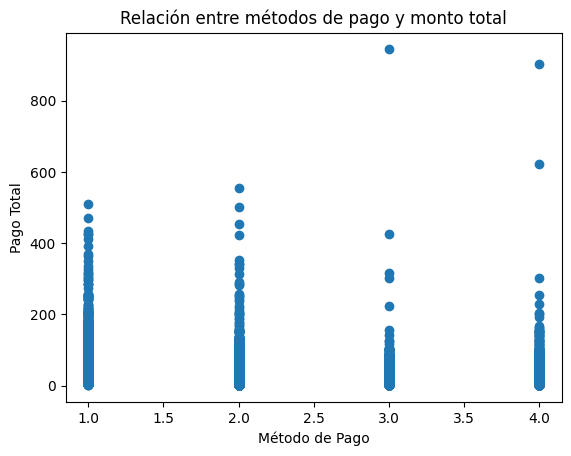

In [ ]:
#data_filtrada['payment_type'] = data_filtrada['payment_type'].replace({1: 'Credito', 2: 'Efectivo',3: 'Sin cargo',4: 'Disputa',5: 'No reconocido',6: 'Pago no procesado'})
#data_filtrada = data[((data['payment_type'] <= 2) & (data['total_amount'] > 0))] #filtramos los metodos de pago a SOLO 2


print(data['payment_type'].unique())
#Tiene el 0, no debería ir porque NO EXISTE ese tipo de pago. Lo filtramos.

print('\n')

print(data['total_amount'].unique())
#No nos mostró todos los únicos pero ya vemos que hay números negativos. No debería haber negativos ni cero.

print(data.shape)
print('\n')

#Filtramos!!
data_filtrada = data[((data['payment_type'] != 0) & (data['total_amount'] > 0))]
print(data_filtrada.shape) #Si miramos la consola, disminuyó mucho.

plt.scatter(data_filtrada['payment_type'], data_filtrada['total_amount']) #tarda demasiado?????
plt.title('Relación entre métodos de pago y monto total')
plt.xlabel('Método de Pago')
plt.ylabel('Pago Total')
plt.show()


In [ ]:

all_locations = pd.concat([data['PULocationID'], data['DOLocationID']]) #Creamos otro dataframe para juntar las locaciones

# Contamos la cantidad de veces que aparece cada ID
location_counts = all_locations.value_counts().reset_index()
location_counts.columns = ['LocationID', 'Count']

# Graficamos el treemap
location_counts['Borough'] = location_counts['LocationID'].map(lambda x: dic_stations.get(x, ('Desconocido', 'Desconocido'))[0])
location_counts['Zone'] = location_counts['LocationID'].map(lambda x: dic_stations.get(x, ('Desconocido', 'Desconocido'))[1])

# Agregamos la ruta jerárquica Borough -> Zone -> LocationID
fig = px.treemap(location_counts,
                 path=['Borough', 'Zone', 'LocationID'],
                 values='Count',
                 title='Tendencia de uso de estaciones de taxi en Manhattan',
                 color_discrete_map={'Borough': 'red'})  # Cambia el color de Manhattan )



fig.show()


Este grafico nos ayuda a ver que estaciones de taxis son las mas usadas, lo que nos muestra como en las zonas mas centricas y pobladas de manhattan, hay mas circulacion de taxis.

La siguiente foto ilustra lo anterior:

 <img src="https://i.imgur.com/KLEhQDx.png" alt="Alt Text" width="800" >

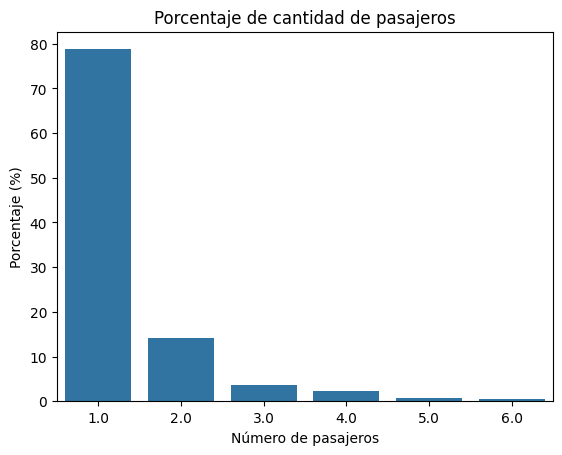

In [ ]:
# Crear el gráfico de barras con countplot
plot = sns.countplot(data=data, x='passenger_count', stat='percent')

# Títulos y etiquetas
plot.set_title('Porcentaje de cantidad de pasajeros')
plot.set_xlabel('Número de pasajeros')
plot.set_ylabel('Porcentaje (%)')

# Mostrar el gráfico
plt.show()

En este grafico, queremos ver cuales son los valores mas usuales de pasajeros (no ponemos foco en ver la diferencia del resto de valores, ya que no es muy relevante)

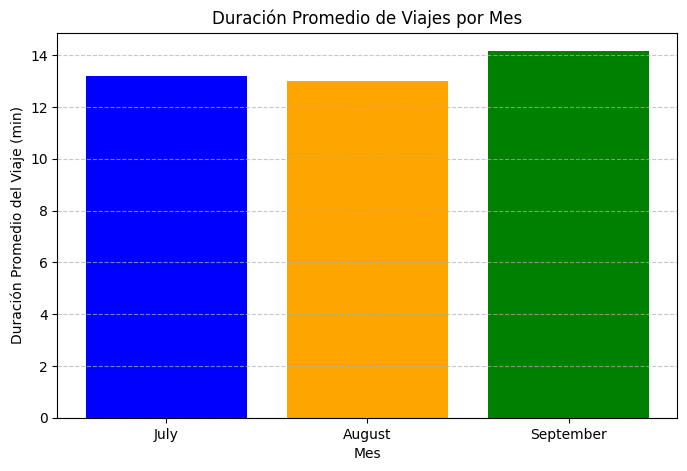

In [ ]:


# Calcular la duración del viaje en minutos
data["duracion_viaje"] = (data["tpep_dropoff_datetime"] - data["tpep_pickup_datetime"]).dt.total_seconds() / 60

# Extraer el mes de la fecha de recogida
data["mes"] = data["tpep_pickup_datetime"].dt.strftime("%B")  # "July", "August", "September"

# Agrupar por mes y calcular la duración promedio del viaje
duracion_promedio_mensual = data.groupby("mes")["duracion_viaje"].mean()

# Ordenar los meses en el orden correcto
orden_meses = ["July", "August", "September"]
duracion_promedio_mensual = duracion_promedio_mensual.reindex(orden_meses)

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(duracion_promedio_mensual.index, duracion_promedio_mensual, color=["blue", "orange", "green"])

# Etiquetas y título
plt.xlabel("Mes")
plt.ylabel("Duración Promedio del Viaje (min)")
plt.title("Duración Promedio de Viajes por Mes")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

108.96


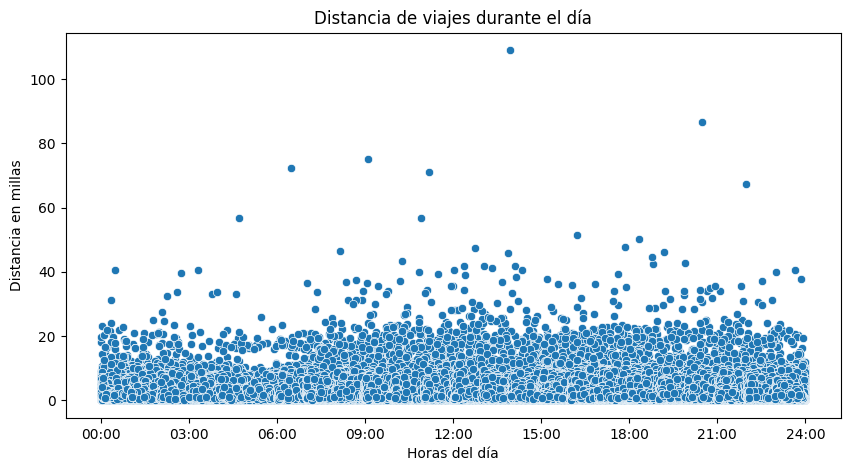

In [ ]:
# Copia de datos y conversión de tiempo
data = data[data["trip_distance"] < 15]

dataf = data.copy()
dataf["segundos_recogida"] = (
    data["tpep_pickup_datetime"].dt.hour * 3600 +
    data["tpep_pickup_datetime"].dt.minute * 60 +
    data["tpep_pickup_datetime"].dt.second
)

# Crear una nueva columna con rangos de 3 horas
dataf["hora_rango"] = (dataf["segundos_recogida"] // (3 * 3600)) * (3 * 3600)

# Crear el heatmap con bins de 3 horas
fig = px.density_heatmap(
    dataf,
    x="hora_rango",
    y="trip_distance",
    nbinsy=15,  # 50 bins para la distancia
    color_continuous_scale="viridis"
)

# Formatear el eje X para mostrar horas en formato HH:mm
fig.update_xaxes(
    tickvals=list(range(0, 86400, 3 * 3600)),  # Ticks cada 3 horas
    ticktext=[f"{h:02d}:00" for h in range(0, 24, 3)],  # Etiquetas HH:00
    title="Hora del día (en rangos de 3 horas)"
)

# Ajustar títulos y etiquetas
fig.update_layout(
    title="Heatmap de distancia vs hora de recogida",
    xaxis_title="Hora del día",
    yaxis_title="Distancia en millas",
    coloraxis_colorbar_title="Cantidad de viajes"
)

# Mostrar el gráfico
fig.show()

Viendo este grafico, podriamos inicialmente deducir que el supuesto que habiamos dicho,parece ser correcto.

Per si vemos bien que alrededor de las 7 AM se acumulan  muchos viajes, de una distancia aproximada de 50.000 millas, nos damos cuenta de que es un trayecto absurdamente largo.


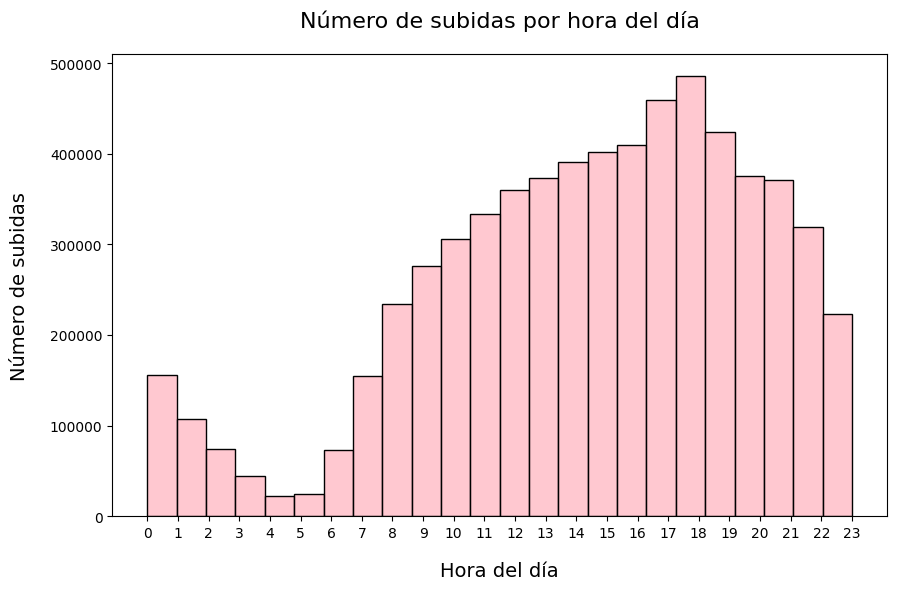

In [ ]:
# Asegurarse de que 'tpep_pickup_datetime' esté en formato datetime
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])

# Crear gráfico de barras (histograma) para las horas del día
plt.figure(figsize=(10, 6))

# Usar un color pastel para el gráfico
sns.histplot(data['tpep_pickup_datetime'].dt.hour, bins=24, kde=False, color='lightpink')

# Títulos y etiquetas
plt.title('Número de subidas por hora del día', fontsize=16, pad=20)  # Título con espacio extra
plt.xlabel('Hora del día', fontsize=14, labelpad=15)  # Eje X con más espacio
plt.ylabel('Número de subidas', fontsize=14, labelpad=15)  # Eje Y con más espacio

# Ajustar los ticks del eje X para que aparezcan todas las horas (0-23)
plt.xticks(range(24))

# Mostrar el gráfico
plt.show()

Dado este gráfico, podemos ver que el momento del día donde más taxis se utilizan es a las 18hs.